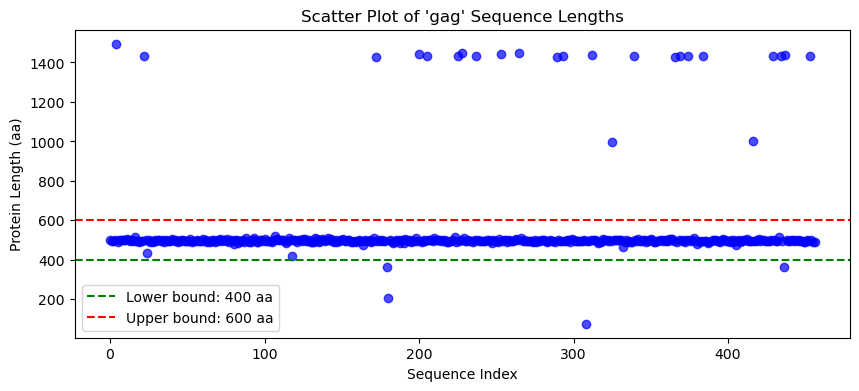

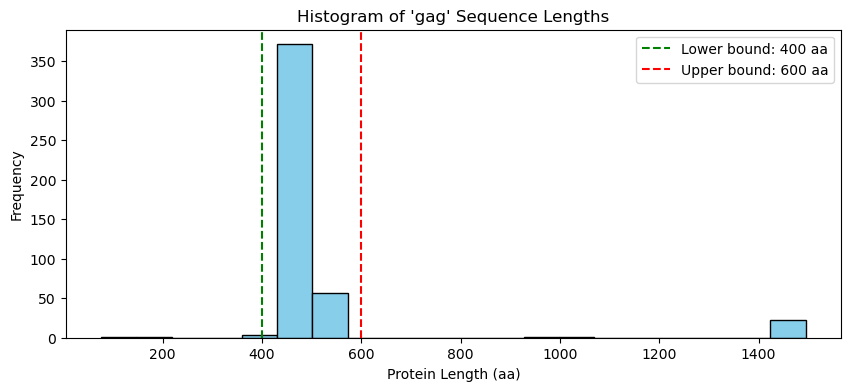

Protein: gag
  Number of sequences: 457
  Fixed interval: 400 – 600 amino acids



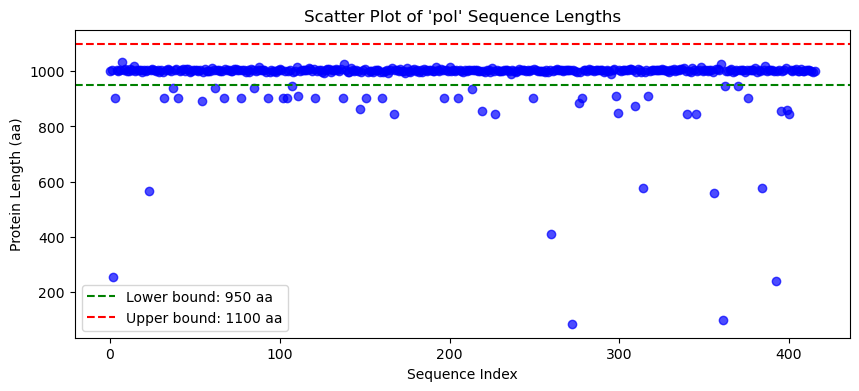

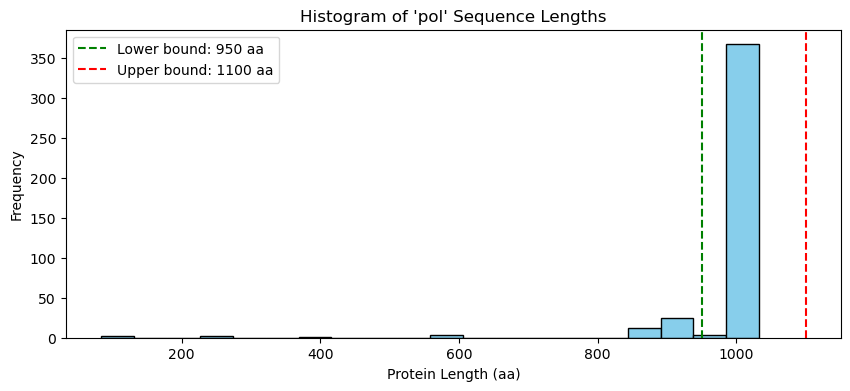

Protein: pol
  Number of sequences: 416
  Fixed interval: 950 – 1100 amino acids



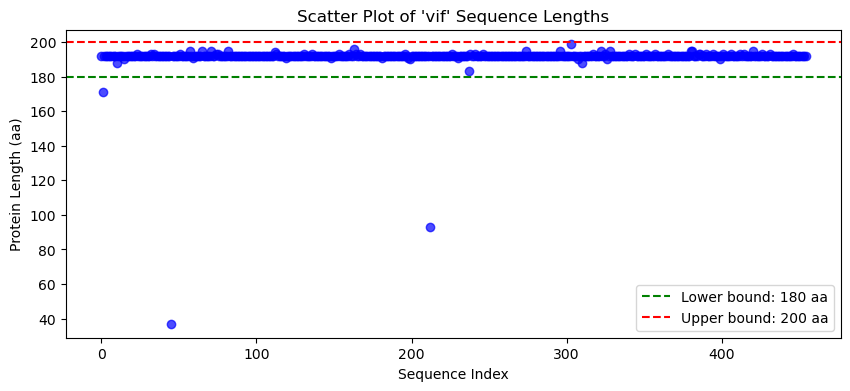

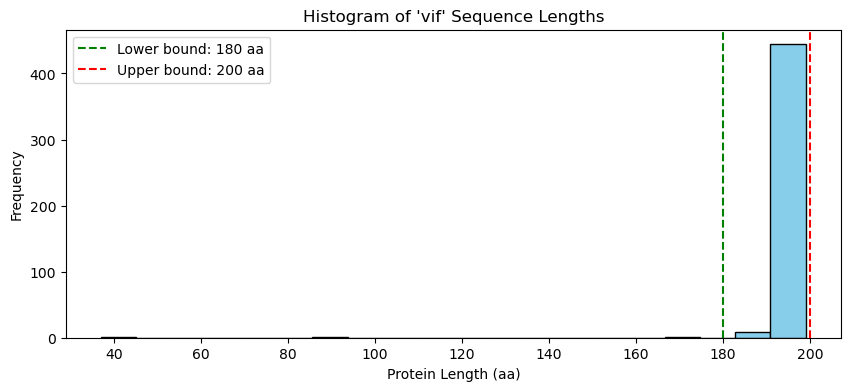

Protein: vif
  Number of sequences: 455
  Fixed interval: 180 – 200 amino acids



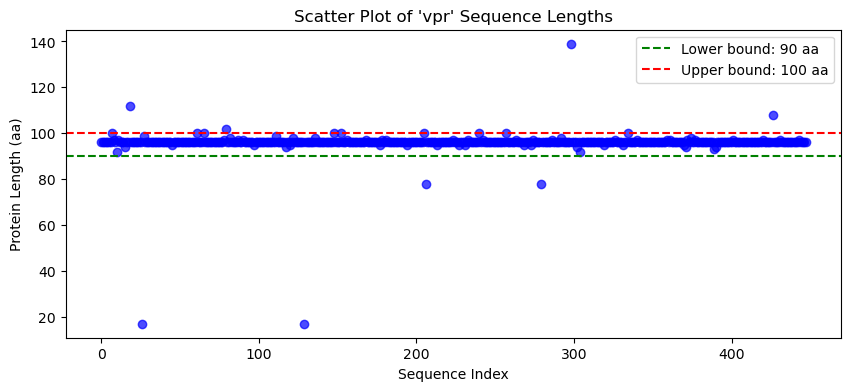

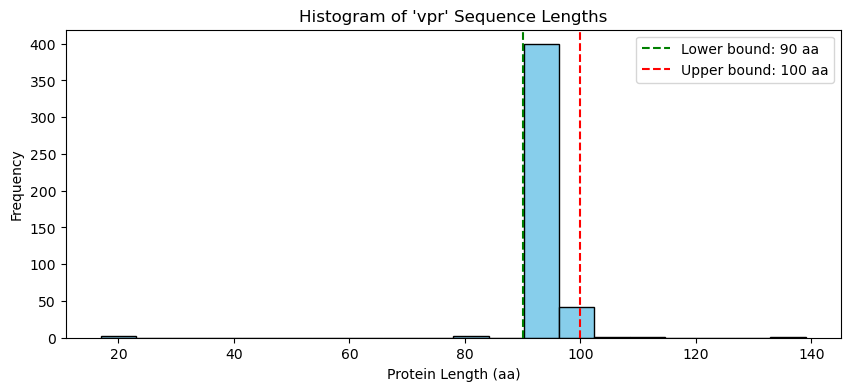

Protein: vpr
  Number of sequences: 448
  Fixed interval: 90 – 100 amino acids



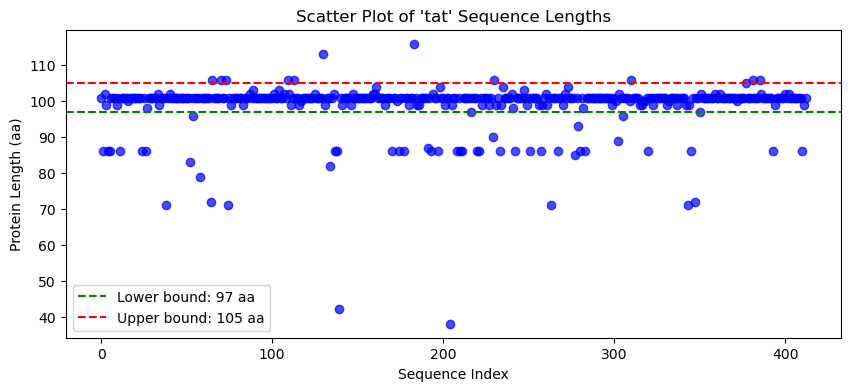

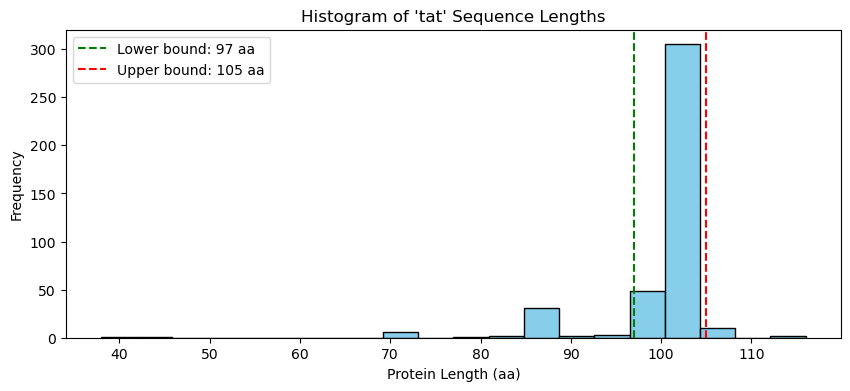

Protein: tat
  Number of sequences: 413
  Fixed interval: 97 – 105 amino acids



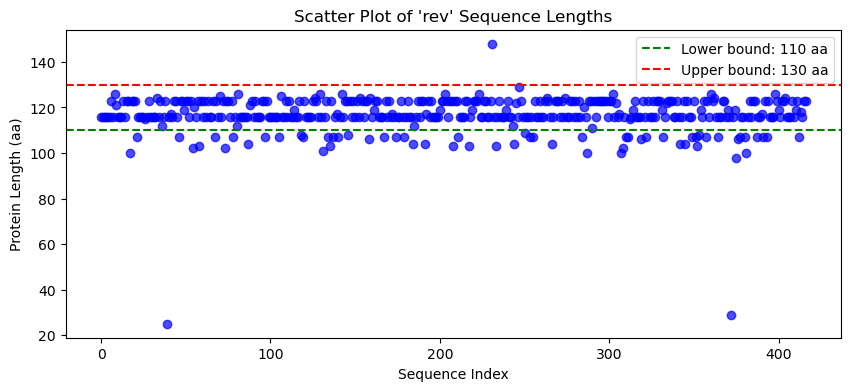

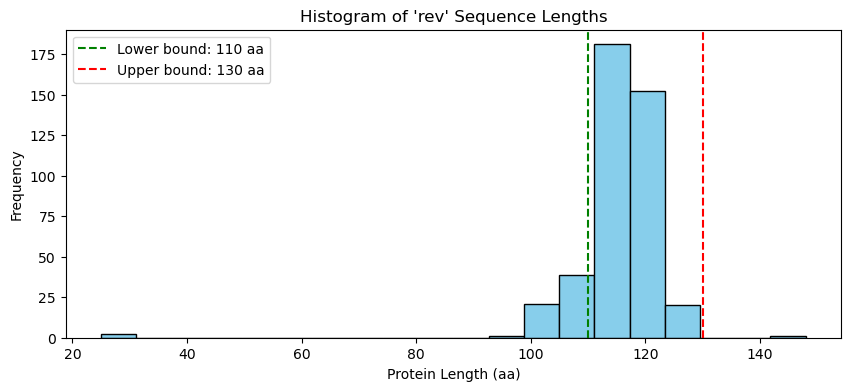

Protein: rev
  Number of sequences: 417
  Fixed interval: 110 – 130 amino acids



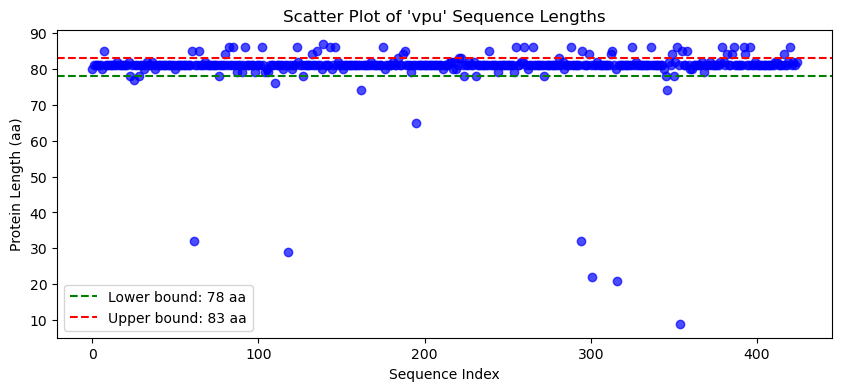

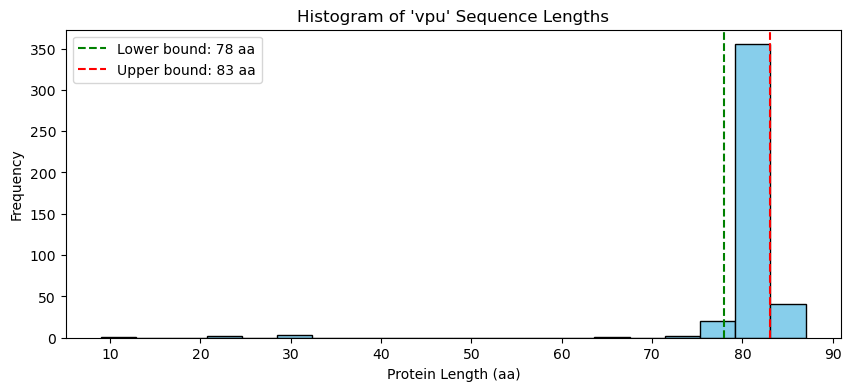

Protein: vpu
  Number of sequences: 425
  Fixed interval: 78 – 83 amino acids



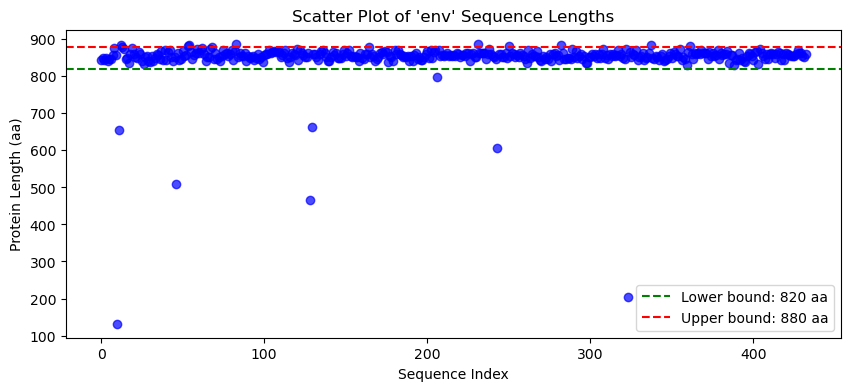

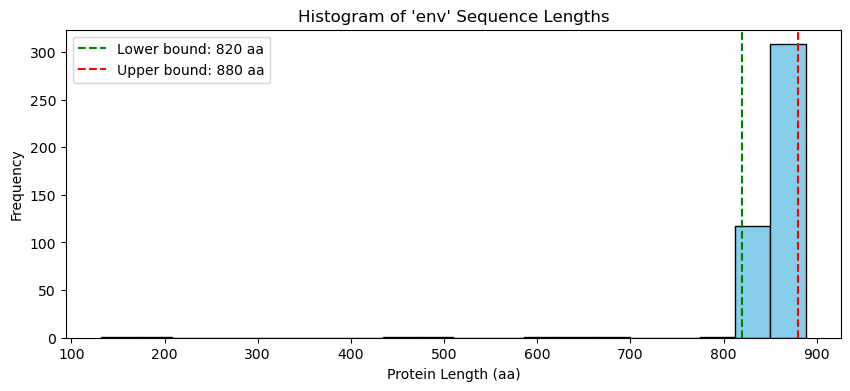

Protein: env
  Number of sequences: 433
  Fixed interval: 820 – 880 amino acids



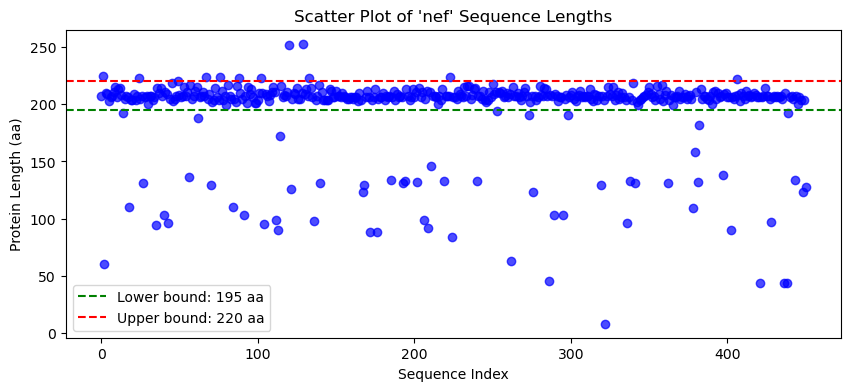

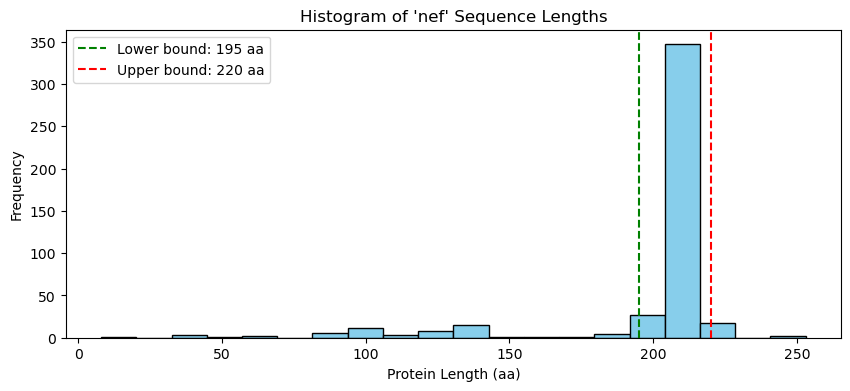

Protein: nef
  Number of sequences: 451
  Fixed interval: 195 – 220 amino acids

Fixed intervals for proteins:
  gag: 400 – 600 aa
  pol: 950 – 1100 aa
  vif: 180 – 200 aa
  vpr: 90 – 100 aa
  tat: 97 – 105 aa
  rev: 110 – 130 aa
  vpu: 78 – 83 aa
  env: 820 – 880 aa
  nef: 195 – 220 aa


In [32]:
import os
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from Bio import SeqIO
from Bio.Seq import Seq

# ====== Parameters ======
# Root directory containing many genome folders (each with HIV annotations)
DATA_DIR = Path("/scratch/pedrobento/sequences_alignment/ncbi_dataset/data")

# Regular expression to extract the protein information from CDS headers.
# Example header: >lcl|AF005496.1_cds_AAD03184.1_1 [protein=gag-pol fusion polyprotein] [...]]
protein_re = re.compile(r'\[protein=(.*?)\]')

# ====== Manual Interval Settings ======
# Only these specific intervals will be used for filtering
INTERVALS = {
    "gag":  (400, 600),
    "pol":  (950, 1100),
    "vif":  (180, 200),
    "vpr":  (90, 100),
    "tat":  (97, 105),
    "rev":  (110, 130),
    "vpu":  (78, 83),
    "env":  (820, 880),
    "nef":  (195, 220)
}

# ====== Normalization Function ======
def normalize_protein_name(raw_name):
    """
    Normalize a raw protein name into a canonical group.
    
    The function converts the name to lowercase, replaces hyphens/underscores with spaces,
    and removes extra words such as "protein", "polyprotein", "precursor", and "fusion".
    It then maps the result to a canonical protein name.
    
    Note: We intentionally do not create a separate group for 'gag-pol' because in HIV the
    gag-pol fusion polyprotein is produced as a precursor that is cleaved into mature Gag and Pol.
    In this pipeline, if both "gag" and "pol" are present, the check for "gag" comes first
    so the sequence is assigned to the "gag" group.
    """
    name = raw_name.lower()
    # Replace hyphens and underscores with a space.
    name = re.sub(r'[\-\_]', ' ', name)
    # Remove common extra words.
    for word in ["protein", "polyprotein", "precursor", "fusion"]:
        name = name.replace(word, '')
    name = ' '.join(name.split())
    # Map to canonical names based on keywords.
    if "gag" in name or "capsid" in name or "matrix" in name:
        return "gag"
    elif "pol" in name or "polymerase" in name:
        return "pol"
    elif "env" in name or "envelope" in name or "gp160" in name:
        return "env"
    elif "tat" in name:
        return "tat"
    elif "rev" in name:
        return "rev"
    elif "nef" in name:
        return "nef"
    elif "vif" in name:
        return "vif"
    elif "vpr" in name:
        return "vpr"
    elif "vpu" in name:
        return "vpu"
    elif "accessory" in name:
        return "accessory"
    elif "regulatory" in name:
        return "regulatory"
    else:
        return name

# ====== Parsing and Grouping ======
def parse_and_group_cds_from_folders(data_dir):
    """
    Iterate over all subfolders in the given data directory. For each folder that contains
    a 'cds_from_genomic.fna' file, parse all CDS records, extract the protein name from the header,
    translate the nucleotide CDS (to_stop=True), and group sequences by the normalized protein name.
    
    Returns:
       A dictionary mapping canonical protein names to a list of tuples: (header, protein_sequence)
    """
    protein_groups = defaultdict(list)
    for folder in data_dir.iterdir():
        if folder.is_dir():
            cds_file = folder / "cds_from_genomic.fna"
            if not cds_file.exists():
                print(f"Warning: {cds_file} not found in folder {folder.name}. Skipping.")
                continue
            for record in SeqIO.parse(str(cds_file), "fasta"):
                header = record.description
                m = protein_re.search(header)
                if not m:
                    continue
                raw_protein = m.group(1).strip()
                canonical_protein = normalize_protein_name(raw_protein)
                
                # Only process proteins in our defined intervals
                if canonical_protein not in INTERVALS:
                    continue
                    
                # Translate the CDS to a protein sequence.
                prot_seq = record.seq.translate(to_stop=True)
                protein_groups[canonical_protein].append((header, str(prot_seq)))
    return protein_groups

def plot_and_analyze_with_fixed_intervals(protein_groups):
    """
    For each protein group (by canonical name), plot a scatter plot and histogram 
    (only if there are at least 10 sequences) using the predefined intervals.
    
    Returns:
       A dictionary mapping each canonical protein name to an interval tuple (lower_bound, upper_bound).
    """
    results = {}
    for protein, records in protein_groups.items():
        # Skip proteins not in our predefined intervals
        if protein not in INTERVALS:
            continue
            
        lengths = [len(seq) for (_, seq) in records]
        if not lengths:
            continue
        
        # Use only predefined intervals
        lower_bound, upper_bound = INTERVALS[protein]
        results[protein] = (lower_bound, upper_bound)
        
        if len(lengths) >= 10:
            # Scatter plot of sequence lengths.
            plt.figure(figsize=(10,4))
            plt.scatter(range(len(lengths)), lengths, color='blue', alpha=0.7)
            plt.xlabel("Sequence Index")
            plt.ylabel("Protein Length (aa)")
            plt.title(f"Scatter Plot of '{protein}' Sequence Lengths")
            plt.axhline(lower_bound, color='green', linestyle='--',
                        label=f"Lower bound: {lower_bound} aa")
            plt.axhline(upper_bound, color='red', linestyle='--',
                        label=f"Upper bound: {upper_bound} aa")
            plt.legend()
            plt.show()
            
            # Histogram of sequence lengths.
            plt.figure(figsize=(10,4))
            plt.hist(lengths, bins=20, edgecolor='black', color='skyblue')
            plt.xlabel("Protein Length (aa)")
            plt.ylabel("Frequency")
            plt.title(f"Histogram of '{protein}' Sequence Lengths")
            plt.axvline(lower_bound, color='green', linestyle='--',
                        label=f"Lower bound: {lower_bound} aa")
            plt.axvline(upper_bound, color='red', linestyle='--',
                        label=f"Upper bound: {upper_bound} aa")
            plt.legend()
            plt.show()
        else:
            print(f"Protein '{protein}' has only {len(lengths)} sequences – skipping plots.")
            
        print(f"Protein: {protein}")
        print(f"  Number of sequences: {len(lengths)}")
        print(f"  Fixed interval: {lower_bound} – {upper_bound} amino acids\n")
    return results

# ====== Main (Cell 1) ======
protein_groups = parse_and_group_cds_from_folders(DATA_DIR)
if not protein_groups:
    print("No protein sequences were found in any folder!")
else:
    intervals = plot_and_analyze_with_fixed_intervals(protein_groups)
    print("Fixed intervals for proteins:")
    for prot, (lb, ub) in intervals.items():
        print(f"  {prot}: {lb} – {ub} aa")

In [33]:
# %% [code]
import subprocess
import sys
import re
from pathlib import Path
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from collections import Counter
from Bio import AlignIO

# ====== Parameters ======
# All MAFFT outputs and related files will be saved in the folder "results"
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# Conservation threshold for determining conserved positions.
CONSERVATION_THRESHOLD = 0.98

# ====== Helper Functions ======
def safe_filename(protein_name):
    """
    Create a safe filename from a protein name by replacing non-alphanumeric characters with underscores.
    """
    return re.sub(r'[^A-Za-z0-9]+', '_', protein_name)

def write_protein_fasta(protein, records, interval, out_dir):
    """
    For a given canonical protein group, filter the sequences so that only those with lengths
    within the given interval (inclusive) are kept. Write these sequences to a FASTA file.
    
    Returns a tuple: (path to the FASTA file, number of sequences written).
    """
    lower_bound, upper_bound = interval
    filtered_records = []
    for header, seq in records:
        if lower_bound <= len(seq) <= upper_bound:
            new_id = header.split()[0].replace(">", "")
            filtered_records.append(SeqRecord(Seq(seq), id=new_id, description=""))
    if not filtered_records:
        return None, 0
    fasta_file = out_dir / f"{safe_filename(protein)}.faa"
    with open(fasta_file, "w") as out_handle:
        SeqIO.write(filtered_records, out_handle, "fasta")
    return fasta_file, len(filtered_records)

def run_mafft(input_fasta, output_fasta):
    """
    Run MAFFT with the '--auto' option on the input FASTA file and write
    the aligned sequences to output_fasta.
    """
    try:
        with open(output_fasta, "w") as out_handle:
            subprocess.run(
                ["mafft", "--auto", str(input_fasta)],
                check=True,
                stdout=out_handle,
                stderr=subprocess.PIPE
            )
        print(f"✅ MAFFT alignment for '{input_fasta.name}' completed. Output saved as '{output_fasta.name}'.")
    except subprocess.CalledProcessError as e:
        print(f"Error running MAFFT on {input_fasta.name}: {e.stderr.decode()}", file=sys.stderr)
        sys.exit(1)

def extract_conserved_regions(alignment_file, output_file, threshold=CONSERVATION_THRESHOLD):
    """
    Read an alignment FASTA file and write a file that contains a single sequence.
    At each alignment column, if the most common residue is present in at least 'threshold'
    fraction of sequences, that residue is output; otherwise, a '-' is placed.
    """
    alignment = AlignIO.read(alignment_file, "fasta")
    num_sequences = len(alignment)
    if num_sequences == 0:
        print("⚠️ No sequences found in alignment.")
        return
    output_sequence = []
    conserved_info = []  # (position, conservation %, residue)
    for i in range(alignment.get_alignment_length()):
        column = [record.seq[i] for record in alignment]
        counts = Counter(column)
        if '-' in counts:
            del counts['-']
        if counts:
            residue, count = counts.most_common(1)[0]
            if count / num_sequences >= threshold:
                output_sequence.append(residue)
                conserved_info.append((i, count / num_sequences * 100, residue))
            else:
                output_sequence.append('-')
        else:
            output_sequence.append('-')
    with open(output_file, "w") as out_handle:
        out_handle.write(
            f">Conserved_Region: {sum(1 for r in output_sequence if r != '-')}/{alignment.get_alignment_length()} positions conserved. Threshold: {threshold*100}%\n"
        )
        out_handle.write("".join(output_sequence) + "\n")
    print(f"✅ Conserved region file saved as '{output_file.name}'.")
    return "".join(output_sequence)  # Return the amalgam sequence

# New helper: Create an amalgam sequence from an alignment.
def create_amalgam_sequence_from_alignment(alignment, threshold=CONSERVATION_THRESHOLD):
    """
    Creates an amalgam sequence where each position is filled with the most common amino acid if
    that amino acid occurs in at least 'threshold' fraction of sequences; otherwise, it is masked with '-'.
    Returns the amalgam sequence as a string.
    """
    num_sequences = len(alignment)
    amalgam = []
    for i in range(alignment.get_alignment_length()):
        column = [record.seq[i] for record in alignment]
        counts = Counter(column)
        if '-' in counts:
            del counts['-']
        if counts:
            residue, count = counts.most_common(1)[0]
            if count / num_sequences >= threshold:
                amalgam.append(residue)
            else:
                amalgam.append('-')
        else:
            amalgam.append('-')
    return "".join(amalgam)

# ====== Main Alignment Pipeline ======
# Make sure that Cell 1 has been run so that 'protein_groups' and 'intervals' exist.
if not globals().get("protein_groups") or not globals().get("intervals"):
    print("Error: Please run Cell 1 (Discovery & Interval Determination) first!")
else:
    amalgam_records = []  # To collect the amalgam sequence (conserved parts) for each protein group.
    for protein, records in protein_groups.items():
        if protein not in intervals:
            print(f"⚠️ Skipping protein '{protein}' because no interval was determined.")
            continue
        fasta_file, count = write_protein_fasta(protein, records, intervals[protein], RESULTS_DIR)
        if not fasta_file or count == 0:
            print(f"⚠️ No sequences for protein '{protein}' passed the length filter.")
            continue
        
        aligned_file = RESULTS_DIR / f"{safe_filename(protein)}_aligned.faa"
        run_mafft(fasta_file, aligned_file)
        
        conserved_file = RESULTS_DIR / f"{safe_filename(protein)}_conserved.faa"
        # extract_conserved_regions writes the conserved region file and returns the amalgam sequence.
        conserved_amalgam = extract_conserved_regions(aligned_file, conserved_file, threshold=CONSERVATION_THRESHOLD)
        
        # Alternatively, one could compute the amalgam sequence directly from the alignment:
        # alignment = AlignIO.read(str(aligned_file), "fasta")
        # conserved_amalgam = create_amalgam_sequence_from_alignment(alignment, threshold=CONSERVATION_THRESHOLD)
        
        # Create a SeqRecord for the amalgam sequence, including the number of sequences that were used.
        record = SeqRecord(Seq(conserved_amalgam), 
                           id=protein, 
                           description=f"Amalgam conserved sequence. Number of sequences: {count}")
        amalgam_records.append(record)
        
        print("\n" + "="*60 + "\n")
        
    # Write the aggregate file with all amalgam (conserved) sequences.
    if amalgam_records:
        amalgam_file = RESULTS_DIR / "amalgam_sequences.faa"
        with open(amalgam_file, "w") as out_handle:
            SeqIO.write(amalgam_records, out_handle, "fasta")
        print(f"✅ Amalgam sequences for all proteins written to '{amalgam_file}'.")
    else:
        print("⚠️ No amalgam sequences were generated.")


✅ MAFFT alignment for 'gag.faa' completed. Output saved as 'gag_aligned.faa'.
✅ Conserved region file saved as 'gag_conserved.faa'.


✅ MAFFT alignment for 'pol.faa' completed. Output saved as 'pol_aligned.faa'.
✅ Conserved region file saved as 'pol_conserved.faa'.


✅ MAFFT alignment for 'vif.faa' completed. Output saved as 'vif_aligned.faa'.
✅ Conserved region file saved as 'vif_conserved.faa'.


✅ MAFFT alignment for 'vpr.faa' completed. Output saved as 'vpr_aligned.faa'.
✅ Conserved region file saved as 'vpr_conserved.faa'.


✅ MAFFT alignment for 'tat.faa' completed. Output saved as 'tat_aligned.faa'.
✅ Conserved region file saved as 'tat_conserved.faa'.


✅ MAFFT alignment for 'rev.faa' completed. Output saved as 'rev_aligned.faa'.
✅ Conserved region file saved as 'rev_conserved.faa'.


✅ MAFFT alignment for 'vpu.faa' completed. Output saved as 'vpu_aligned.faa'.
✅ Conserved region file saved as 'vpu_conserved.faa'.


✅ MAFFT alignment for 'env.faa' completed. Output saved as 'en

In [36]:
import csv
from pathlib import Path
from Bio import SeqIO

def generate_possible_sequences(fasta_file, output_csv, min_length=9, max_length=12):
    """
    Reads a FASTA file with conserved/amalgam sequences (where '-' denotes a non-conserved position),
    extracts all contiguous substrings of length between min_length and max_length (only considering
    blocks of amino acids without gaps), and writes them to a CSV file along with the protein name.
    
    Parameters:
        fasta_file (Path): Path to the input FASTA file.
        output_csv (Path): Path to the output CSV file.
        min_length (int): Minimum length of substrings to extract.
        max_length (int): Maximum length of substrings to extract.
    """
    possible_sequences = []

    # Read each record from the FASTA file.
    for record in SeqIO.parse(fasta_file, "fasta"):
        protein_name = record.id  # Assuming the protein name is stored in the record ID.
        seq_str = str(record.seq)
        # Split by '-' to get only the conserved parts.
        blocks = seq_str.split('-')
        for block in blocks:
            # Only consider blocks that are long enough.
            if len(block) < min_length:
                continue
            # For each block, generate all contiguous substrings with lengths between min_length and max_length.
            # We ensure we don't ask for a substring longer than the block itself.
            for L in range(min_length, min(max_length, len(block)) + 1):
                for start in range(0, len(block) - L + 1):
                    substring = block[start:start + L]
                    possible_sequences.append((substring, len(substring), protein_name))
    
    # Write the results to a CSV file.
    with open(output_csv, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Sequence", "Length", "Protein"])  # Header row
        writer.writerows(possible_sequences)
    
    print(f"✅ Possible sequences saved in CSV file '{output_csv}'.")

# Define file paths. (Adjust these paths if needed.)
input_fasta = Path("results") / "amalgam_sequences.faa"
output_csv = Path("epitopes") / "possible_sequences.csv"

# Certifique-se de que o diretório de saída exista
Path("epitopes").mkdir(exist_ok=True)

# Generate possible sequences and save them to CSV.
# Modificado para usar intervalo de 9 a 12
generate_possible_sequences(input_fasta, output_csv, min_length=9, max_length=12)

✅ Possible sequences saved in CSV file 'epitopes/possible_sequences.csv'.


✅ Histogram saved as 'epitopes/sequence_length_histogram.png'.


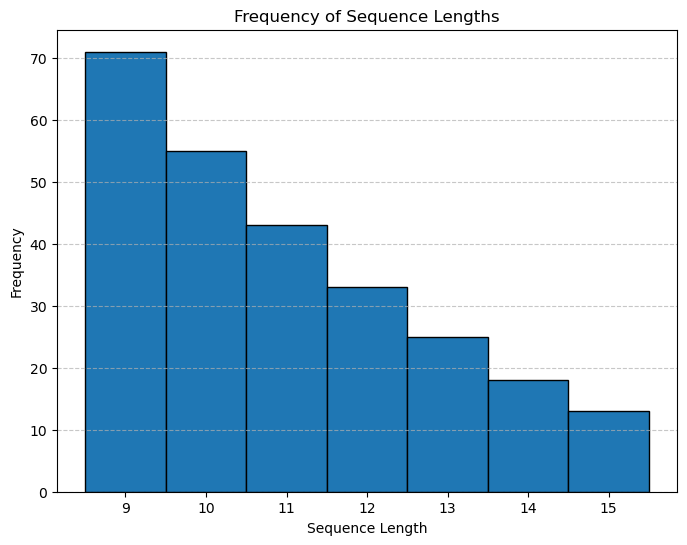

In [7]:
import csv
from pathlib import Path
import matplotlib.pyplot as plt

def plot_sequence_length_histogram(csv_file):
    """
    Reads a CSV file with the format:
        Sequence,Length,Protein
    and plots a histogram of the frequency of each sequence length.
    """
    lengths = []
    
    # Read the CSV file and collect sequence lengths
    with open(csv_file, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Convert the length value from string to integer
            lengths.append(int(row["Length"]))
    
    if not lengths:
        print("No sequence lengths found in the file.")
        return
    
    # Determine the range for the histogram bins
    min_length = min(lengths)
    max_length = max(lengths)
    
    # Create the histogram plot
    plt.figure(figsize=(8, 6))
    bins = range(min_length, max_length + 2)  # +2 to include the last bin edge
    plt.hist(lengths, bins=bins, align="left", edgecolor="black")
    plt.title("Frequency of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.xticks(range(min_length, max_length + 1))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Save the plot to a file
    output_plot = Path("epitopes") / "sequence_length_histogram.png"
    #plt.savefig(output_plot)
    print(f"✅ Histogram saved as '{output_plot}'.")
    
    # Display the plot
    plt.show()

# Define the path to the CSV file (adjust if needed)
csv_file_path = Path("epitopes") / "possible_sequences.csv"

# Plot the histogram
plot_sequence_length_histogram(csv_file_path)
